# Import libraries and dataset


In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [48]:
#Load dataset
file_id = '1wxA4yskGxdyBAuEcKG3p_gx1mgsD9Vyh'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

# Exploratory Data Analysis

## Shape of the dataset

In [49]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (43546, 17)


## Missing values

In [50]:
# Count missing values per column
missing_values = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing_values)

Missing values per column:
 Randomized Latest Child Invoice    37602
Marketplace                            0
Invoice Date                           0
Invoice Status                         0
Payment Due Date                       0
Paid Amount Currency                   0
Payee                                  0
Invoice Creation Date                  0
Actual Paid Amount                     0
Randomized Invoice                     0
Invoice Amount                         0
Any Deductions                         0
Invoice Currency                       0
Quantity Variance Amount               0
Price Variance Amount                  0
Quick Pay Discount Amount              0
Randomized PO                          0
dtype: int64


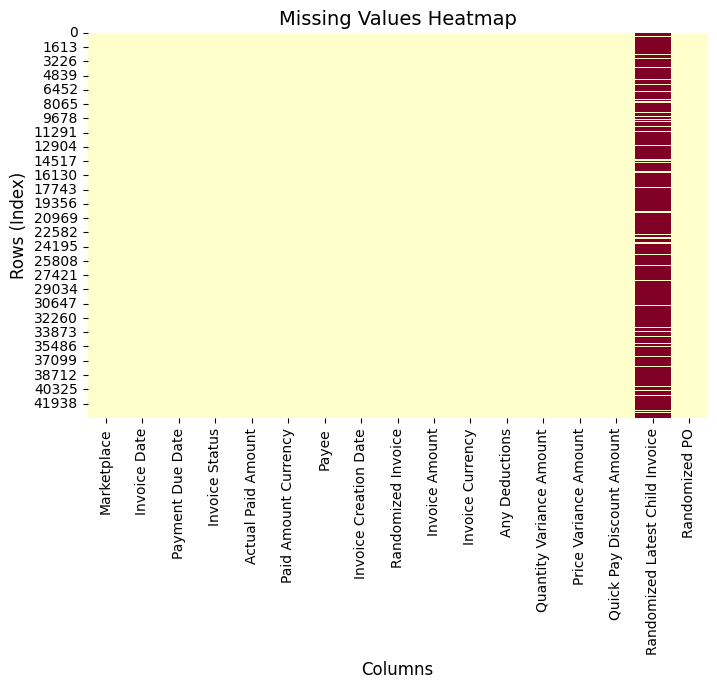

In [51]:
# Heatmap of missing values
plt.figure(figsize=(8,5))
sns.heatmap(df.isnull(), cbar=False, cmap="YlOrRd")
plt.title("Missing Values Heatmap", fontsize=14)
plt.xlabel("Columns", fontsize=12)
plt.ylabel("Rows (Index)", fontsize=12)
plt.show()

Only the column `Randomized Latest Child Invoice` has nulls.

## Count duplicates, if any

In [52]:
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


## Basic description of numerical variables included in the dataset,

In [53]:
# Describe numerical columns
numerical_cols = ['Actual Paid Amount', 'Invoice Amount', 'Any Deductions',
                  'Quantity Variance Amount', 'Price Variance Amount',
                  'Quick Pay Discount Amount']
print(df[numerical_cols].describe())

       Actual Paid Amount  Invoice Amount  Quantity Variance Amount  \
count        4.354600e+04    4.354600e+04              43546.000000   
mean         3.151133e+03    3.377625e+03                 20.162538   
std          1.890414e+04    1.966881e+04                608.083974   
min          0.000000e+00    1.200000e+00                  0.000000   
25%          1.260000e+02    1.401000e+02                  0.000000   
50%          3.231000e+02    3.434200e+02                  0.000000   
75%          1.162923e+03    1.312500e+03                  0.000000   
max          1.303012e+06    1.393355e+06              57015.340000   

       Price Variance Amount  Quick Pay Discount Amount  
count           43546.000000               43546.000000  
mean                8.856946                  26.199098  
std               150.023697                  90.628070  
min             -2004.000000                 -14.950000  
25%                 0.000000                   1.060000  
50%         

## Which are the unique values present in the categorical attributes

In [54]:
categorical_cols = ['Marketplace', 'Invoice Status', 'Paid Amount Currency', 'Invoice Currency']
for col in categorical_cols:
    print(f"\n{col} - Unique values:\n", df[col].value_counts())


Marketplace - Unique values:
 Marketplace
US    43546
Name: count, dtype: int64

Invoice Status - Unique values:
 Invoice Status
PAID                                 41710
PAID, PRICE_DISCREPANCY               1016
PROCESSING, PENDING_AMAZON_ACTION      662
QUEUED_FOR_PAYMENT                     158
Name: count, dtype: int64

Paid Amount Currency - Unique values:
 Paid Amount Currency
USD    43546
Name: count, dtype: int64

Invoice Currency - Unique values:
 Invoice Currency
USD    43546
Name: count, dtype: int64


# 1.- Total Shortage Amount (in dollars) from the dataset.

In [55]:
#Convert to data type
df['Invoice Amount'] = pd.to_numeric(df['Invoice Amount'], errors='coerce')
df['Actual Paid Amount'] = pd.to_numeric(df['Actual Paid Amount'], errors='coerce')
#Render specifically what Amazon did not pay for.
df['Total Variance'] = df['Invoice Amount'] - df['Actual Paid Amount']
total_variance = df['Total Variance'].sum()

print(f"Total Variance Between Invoice and Paid (USD): ${total_variance:,.2f}")

Total Variance Between Invoice and Paid (USD): $9,862,786.80


/tmp/ipython-input-1756075961.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range_counts.index, y=range_counts.values, palette='Blues_d')


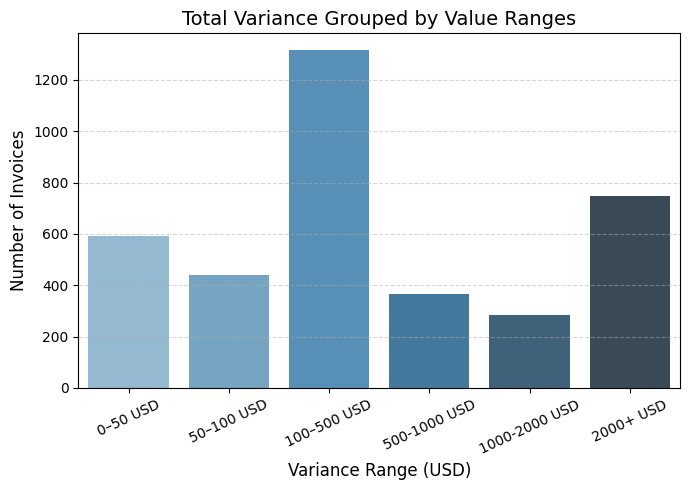

In [56]:
# Drop NaN values for plotting a histogram with intervals/grouping of shortages ammount in the dataset
# Filter out NaN and negative values if any
variance_data = df['Total Variance'].dropna()
variance_data = variance_data[variance_data > 0]

# Define bins and labels + cut data into bins
bins = [0, 50, 100, 500, 1000, 2000, variance_data.max()]
labels = ['0–50 USD', '50–100 USD', '100–500 USD', '500-1000 USD', '1000-2000 USD', '2000+ USD']
df['Variance Range'] = pd.cut(variance_data, bins=bins, labels=labels, include_lowest=True)
range_counts = df['Variance Range'].value_counts().sort_index()

# Plot barplot
plt.figure(figsize=(7,5))
sns.barplot(x=range_counts.index, y=range_counts.values, palette='Blues_d')
plt.title('Total Variance Grouped by Value Ranges', fontsize=14)
plt.xlabel('Variance Range (USD)', fontsize=12)
plt.ylabel('Number of Invoices', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

## 📄Analysis

* The total shortage amount across all invoices is approximately: USD $9,862,786.80. This figure represents the difference between the amounts invoiced and the amounts actually paid by Amazon to the supplier.

* The shortages are not evenly distributed. When categorizing them by value ranges, we observe the following:

  + The most common discrepancies fall within the 500–1000 USD range. This range accounts for a large number of transactions, indicating a frequent but moderate level of underpayment across many invoices.

  + The second most impactful category consists of shortages greater than 2,000 USD. While less frequent, these high-value discrepancies significantly inflate the total shortage amount, contributing disproportionately to the overall financial gap.



## 📈 Extra analysis: identifying high-impact transactions and get them ready to cross-reference with shipping records and invoice metadata.


/tmp/ipython-input-2115595241.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total Variance', y='Randomized Invoice', data=plot_data, palette='Reds_r')


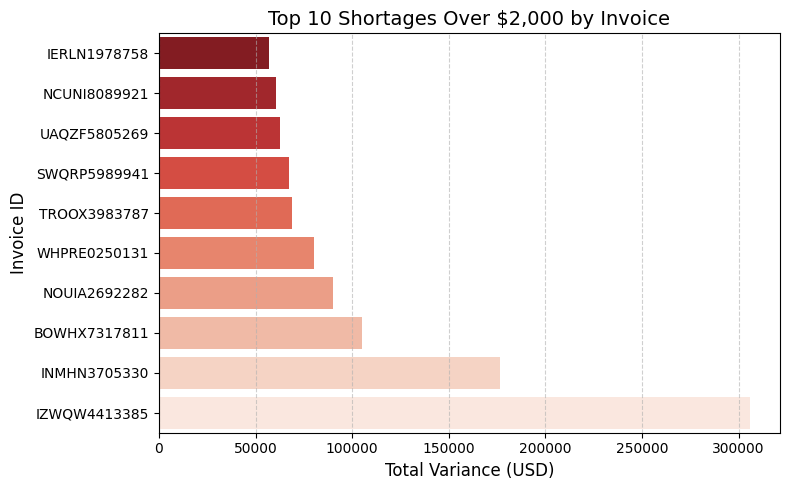

In [57]:
# Sort and select top 10 - could be customized
high_shortages = df[df['Total Variance'] > 2000]
top_10_shortages = high_shortages.sort_values(by='Total Variance', ascending=False).head(10)
columns_to_review = ['Randomized Invoice', 'Invoice Date', 'Invoice Amount', 'Actual Paid Amount',
                     'Total Variance', 'Marketplace', 'Randomized PO', 'Payment Due Date']
plot_data = top_10_shortages.sort_values(by='Total Variance', ascending=True)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='Total Variance', y='Randomized Invoice', data=plot_data, palette='Reds_r')
plt.title('Top 10 Shortages Over $2,000 by Invoice', fontsize=14)
plt.xlabel('Total Variance (USD)', fontsize=12)
plt.ylabel('Invoice ID', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Next steps....

Cross-reference with:

* Shipping Records:	Confirm units were actually shipped (e.g. tracking)
* Invoice Metadata:	Double-check invoice creation date, status, and currency
* Payment Terms:	See if the deduction was timing-related (e.g. early payment)


# 2.-	Annual Breakdown of Shortages to understand trends over time

In [58]:
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'], errors='coerce')
df['Year'] = df['Invoice Date'].dt.year
df['Invoice Amount'] = pd.to_numeric(df['Invoice Amount'], errors='coerce')
df['Actual Paid Amount'] = pd.to_numeric(df['Actual Paid Amount'], errors='coerce')
df['Total Variance'] = df['Invoice Amount'] - df['Actual Paid Amount']

# Group by year
annual_shortages = df.groupby('Year')['Total Variance'].sum().reset_index()
print(annual_shortages)

     Year  Total Variance
0  2021.0       244386.87
1  2022.0       394790.71
2  2023.0       134363.77
3  2024.0       677623.95
4  2025.0      1320341.77


/tmp/ipython-input-3411563167.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=annual_shortages, x='Year', y='Total Variance', palette='Blues_d')


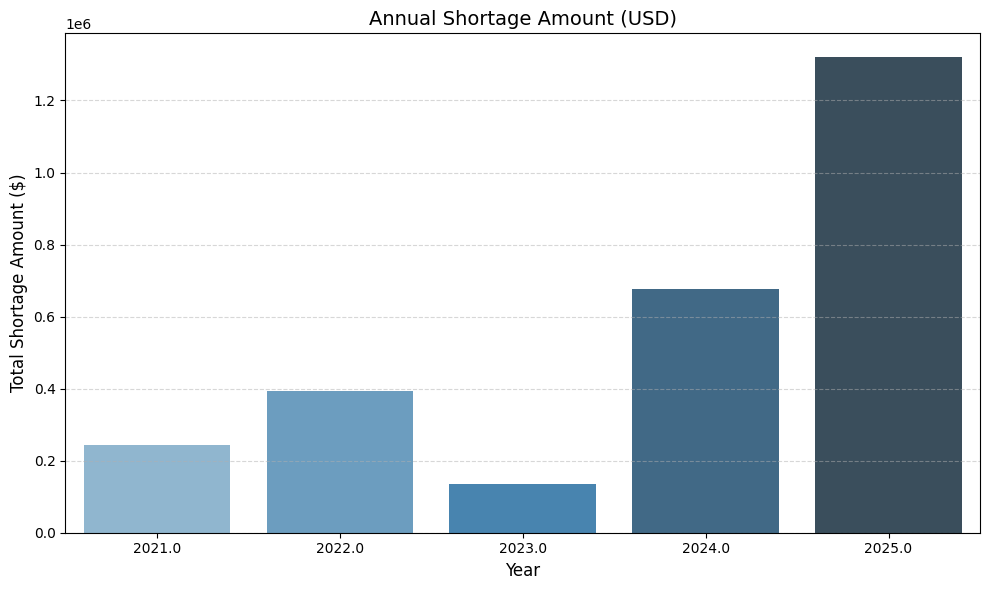

In [59]:
#Plot annual trend
plt.figure(figsize=(10,6))
sns.barplot(data=annual_shortages, x='Year', y='Total Variance', palette='Blues_d')
plt.title('Annual Shortage Amount (USD)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Shortage Amount ($)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 📄 Shortage Trend Analysis (2021–2025)

The analysis of annual shortage data between 2021 and 2025 reveals that:

* Shortages varied from year to year between 2021 and 2024, showing no consistent upward or downward trend during that period. However, in 2025, there has been an alarming increase in the total shortage amount, marking a significant deviation from previous years.

* This spike may indicate systemic issues such as fulfillment discrepancies, operational bottlenecks, or changes in Amazon’s reconciliation process. Further investigation is recommended to identify the root causes and prevent future underpayments.



# 3.- 	Aged Shortages Amount per year.

This analysis which will render insights into how much money is still unpaid well past the expected resolution window (90+ days overdue). These aged shortages are key for prioritizing dispute and recovery actions.


In [60]:
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'], errors='coerce')
df['Payment Due Date'] = pd.to_datetime(df['Payment Due Date'], errors='coerce')
df['Invoice Amount'] = pd.to_numeric(df['Invoice Amount'], errors='coerce')
df['Actual Paid Amount'] = pd.to_numeric(df['Actual Paid Amount'], errors='coerce')
today = pd.to_datetime('2025-07-30')  # Fixed analysis date, using today's date for analysis.
df['Days Past Due'] = (today - df['Payment Due Date']).dt.days
df['Aged Shortage'] = (df['Days Past Due'] > 90) & (df['Total Variance'] > 0)
df['Invoice Year'] = df['Invoice Date'].dt.year
aged_df = df[df['Aged Shortage']]
aged_shortages_by_year = aged_df.groupby('Invoice Year')['Total Variance'].sum().reset_index()

/tmp/ipython-input-1146252625.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Payment Due Date'] = pd.to_datetime(df['Payment Due Date'], errors='coerce')


/tmp/ipython-input-1255532948.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=aged_shortages_by_year, x='Invoice Year', y='Total Variance', palette='OrRd')


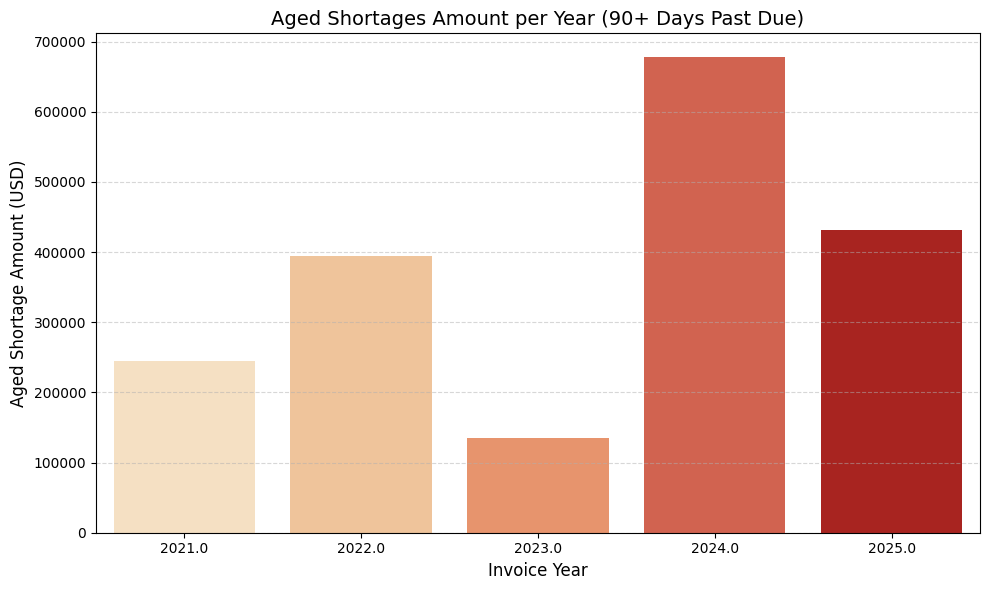

In [61]:
# Plot the result
plt.figure(figsize=(10,6))
sns.barplot(data=aged_shortages_by_year, x='Invoice Year', y='Total Variance', palette='OrRd')
plt.title('Aged Shortages Amount per Year (90+ Days Past Due)', fontsize=14)
plt.xlabel('Invoice Year', fontsize=12)
plt.ylabel('Aged Shortage Amount (USD)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 📄 Aged Shortages Yearly Analysis

* The analysis of aged shortages—defined as invoice underpayments outstanding for more than 90 days past their due date—reveals that the years 2025 and 2024 represent the highest concentrations of aged shortages. These two years account for a significant portion of the total aged shortage amount, indicating a recent and growing issue with delayed or disputed payments.

* By contrast, prior years (2023 and earlier) show relatively lower aged shortage amounts. This suggests that older discrepancies may have already been resolved, or that the volume and scale of shortages have increased more recently, potentially due to changes in operational processes, order volumes, or reconciliation procedures on Amazon’s side.

* The results highlight the urgency of focusing dispute resolution efforts on invoices issued in 2024 and 2025, where the financial exposure is currently the greatest.



# 4.- Going Furhter

The problem proposed with Amazon suppliers is a classic supply chain reconciliation problem where your role is to build a data-driven case to defend your client (the supplier) and prove that Amazon’s shortages are not valid. The questions are which invoices show price variances and are there patterns in such invoices?

To analyze this I suggest the following actions.

### 📊 1) Create a detailed list of the top x aged, high-value invoices with columns like: Randomized Invoice, Invoice Date, Total Variance, Marketplace, Randomized PO.
Then export this as a working file for audit teams or dispute submission:



In [62]:
top_aged = 20 #Or vary as needed
target_invoices = df[df['Aged Shortage'] & (df['Total Variance'] > 2000)]
top_targets = target_invoices.sort_values(by='Total Variance', ascending=False).head(top_aged)
# Export report
top_targets.to_excel('Top_Aged_High_Value_Invoices.xlsx', index=False)

###  📊 2) Cross-Reference with Shipment Evidence

If you have access to external shipment data (tracking logs, BOLs, warehouse scans), now is the time to cross-validate these invoices:

* Match Randomized PO to shipping logs
* Confirm delivery time and tracking
* Find warehouse receipts

### 📊 3) Analyze by Marketplace and Vendor

* Break down shortages by Marketplace and Payee. This could reveal whether:
* Certain Amazon regional markets are more prone to disputes
* Some clients or invoice handlers are systematically missing validation ste

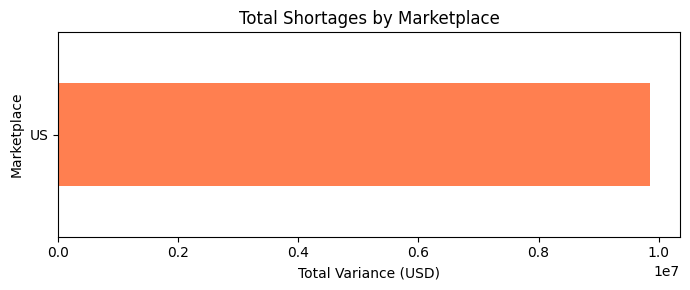

In [63]:
shortages_by_marketplace = df.groupby('Marketplace')['Total Variance'].sum().sort_values(ascending=False)
plt.figure(figsize=(7,3))
shortages_by_marketplace.plot(kind='barh', color='coral')
plt.title('Total Shortages by Marketplace')
plt.xlabel('Total Variance (USD)')
plt.tight_layout()
plt.show()


# 📋 5.- Final Deliverable


* Summary of case of study

  + Total shortages: 9.86M USD.
  + Top 2 years with most aged shortages: 2025 and 2024.
  + Shortages often range from 500-1000 USD, but largest impact comes from $2,000+ cases.

* Priority Actions
  + Focus dispute on top aged, high-value invoices.
  + Cross-reference with shipping and PO confirmations.
  + Audit marketplaces with highest unresolved shortages.
